In [1]:
# project: p6
# submitter: yzhang2232
# partner: none
# hours: 6

In [2]:
import pandas as pd
import geopandas as gpd
import sqlite3
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import rasterio
from rasterio.mask import mask

In [3]:
main = gpd.read_file('counties.geojson')
main

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."
...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070..."
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725..."
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553..."
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830..."


In [4]:
#q1
len(main)

72

<AxesSubplot:>

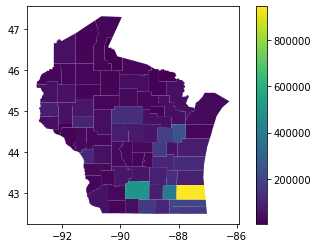

In [5]:
#q2
main.plot(column = 'POP100', legend = True)

In [6]:
conn = sqlite3.connect("counties_tracts.db")
counties = pd.read_sql("""SELECT * FROM counties""", conn)
main['AREALAND'] = counties['AREALAND']
train, test = train_test_split(main, random_state=320, test_size=0.25)

In [7]:
#q3
list(test["NAME"])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [8]:
#q4
model = LinearRegression()
model.fit(train[['AREALAND']], train['POP100'])
model.score(test[['AREALAND']], test['POP100'])

0.022002661530554857

In [9]:
#q5
predict_df = pd.DataFrame({'AREALAND':[500*2.59*1000000]})
model.predict(predict_df)[0]

82032.53073541154

In [10]:
#q6
tracts = pd.read_sql("""
SELECT counties.NAME, tracts.COUNTY, SUM(HU100) AS HU100
FROM tracts INNER JOIN counties
ON tracts.COUNTY = counties.COUNTY
GROUP BY tracts.COUNTY""", conn)
main = pd.merge(left=main, right=tracts, how="inner", on="NAME")
train, test = train_test_split(main, random_state=320, test_size=0.25)
list(test['NAME'])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [11]:
#q7
dict(zip(train.NAME, train.HU100))

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [12]:
#q8
model = LinearRegression()
sum(cross_val_score(model, train[['HU100']], train['POP100']))/5

0.9652534544116037

In [13]:
#q9
cross_val_score(model, train[['HU100']], train['POP100']).std()

0.03704265206670459

In [14]:
#q10
model = LinearRegression()
model.fit(train[['HU100']], train['POP100'])
'POP100 = {0:.2f}*HU100 + {1:.2f}'.format(model.coef_[0], model.intercept_)

'POP100 = 2.39*HU100 + -7910.46'

Text(226022, 478073, 'Dane')

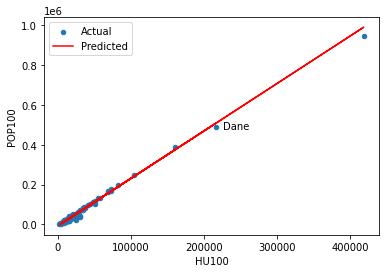

In [15]:
#q11
main['PREDI_POP100'] = model.predict(main[['HU100']])
ax = main.plot.scatter(x="HU100",y="POP100", label='Actual')
main.plot.line(x="HU100",y="PREDI_POP100", color="red", label='Predicted', ax=ax)
x = main.set_index('NAME').loc['Dane County', 'HU100']
y = main.set_index('NAME').loc['Dane County', 'POP100']
ax.text(x+10000, y-10000,'Dane')

In [16]:
#q12
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])
((A >= 2) & (A <= 5)).astype(int).sum()

12

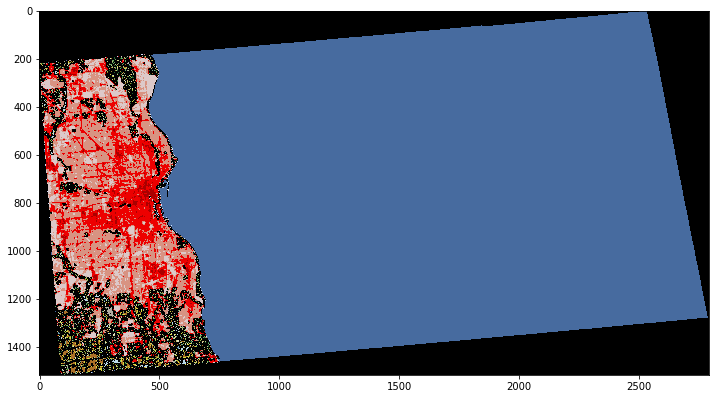

In [17]:
#q13
land = rasterio.open("zip://../p6/land.zip!wi.tif")
mil = main[main['NAME']=='Milwaukee County'][['NAME','geometry']]
matrix, _ = mask(land, mil.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [18]:
#q14
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}
len(matrix[matrix == land_use['open_water']])/len(matrix[matrix != 0])

0.7963037455950543

Text(0.5, 1.0, 'Relationship Between POP100 and Grassland')

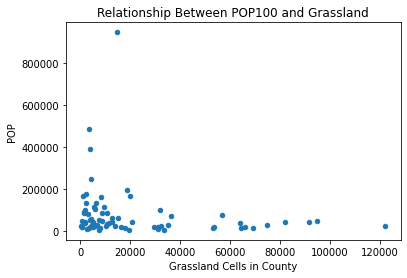

In [19]:
#q15
grassland = []
for i in range(len(main)):
    matrix, _ = mask(land, main.loc[[i]].to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    grassland.append(len(matrix[matrix == land_use['grassland']]))
main['grassland'] = grassland
ax = main.plot.scatter(x="grassland",y="POP100")
ax.set_xlabel("Grassland Cells in County")
ax.set_ylabel("POP")
ax.set_title("Relationship Between POP100 and Grassland")

Text(0, 0.5, 'R^2 Score')

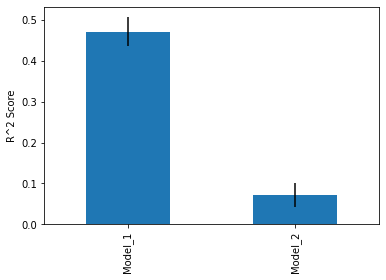

In [20]:
#q16
own = gpd.read_file('tracts.geojson')
deve_open = []
deve_low = []
deve_med = []
deve_high = []
for i in range(len(own)):
    matrix, _ = mask(land, own.loc[[i]].to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    deve_open.append(len(matrix[matrix == land_use['developed_open']]))
    deve_low.append(len(matrix[matrix == land_use['developed_low']]))
    deve_med.append(len(matrix[matrix == land_use['developed_med']]))
    deve_high.append(len(matrix[matrix == land_use['developed_high']]))
own['developed_open'] = deve_open
own['developed_low'] = deve_low
own['developed_med'] = deve_med
own['developed_high'] = deve_high
train, test = train_test_split(own, random_state=320)

model1 = Pipeline([
    ('poly', PolynomialFeatures(degree = 2, include_bias=False)),
    ('model',LinearRegression()),
])
model2 = LinearRegression()

scores1 = cross_val_score(model1, train[['developed_high','developed_low','developed_open','developed_med']], train['POP100'])
scores2 = cross_val_score(model2, train[['developed_high']], train['POP100'])

avg = pd.Series({"Model_1": scores1.mean(), "Model_2": scores2.mean()})
std = pd.Series({"Model_1": scores1.std(), "Model_2": scores2.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")

In [21]:
#q17

### I would recommend model 1. As from the above question, 
### it is clear that with similar standard deviation of scores,
### model 1 has much higher scores. Though it has four features and 
### degree of 2, which migh seems to be a little redundant,
### from the precision perspective, I would still recommend it.

model1.fit(train[['developed_open','developed_low','developed_med','developed_high']], train['POP100'])
model1.score(test[['developed_open','developed_low','developed_med','developed_high']], test['POP100'])

0.4682740740806324